In [99]:
import scipy
import os
import numpy as np
import matplotlib.pyplot as plt
seq_dim=(6,6)

In [ ]:
d = scipy.stats.expon().rvs(size=1000)
plt.hist(d)

In [100]:
import torch
import seaborn as sns
from torch.autograd import grad as torchgrad

In [101]:

def HMCwithAccept(energy,x,length,steps,epsilon):
    shape = [i if no==0 else 1 for no,i in enumerate(x.shape)]
    def grad(z):
        return torchgrad(energy(z),z,grad_outputs=z.new_ones(z.shape[0]))[0]

    torch.set_grad_enabled(False)
    E = energy(x)
    torch.set_grad_enabled(True)
    g = grad(x.requires_grad_())
    torch.set_grad_enabled(False)
    g = g.detach()
    for l in range(length):
        p = x.new_empty(size=x.size()).normal_()
        H = ((0.5*p*p).reshape(p.shape[0], -1).sum(dim=1) + E)
        xnew = x
        gnew = g
        for _ in range(steps):
            p = p- epsilon* gnew/2.
            xnew = (xnew + epsilon * p)
            torch.set_grad_enabled(True)
            gnew = grad(xnew.requires_grad_())
            torch.set_grad_enabled(False)
            xnew = xnew.detach()
            gnew = gnew.detach()
            p = p- epsilon* gnew/2.
        Enew = energy(xnew)
        Hnew = (0.5*p*p).reshape(p.shape[0], -1).sum(dim=1) + Enew
        diff = H-Hnew
        accept = (diff.exp() >= diff.uniform_()).to(x)

        E = accept*Enew + (1.-accept)*E
        acceptMask = accept.reshape(shape)
        x = acceptMask*xnew + (1.-acceptMask)*x
        g = acceptMask*gnew + (1.-acceptMask)*g
    torch.set_grad_enabled(True)

    return x, accept

def HMC(*args,**kwargs):
    x, _ = HMCwithAccept(*args,**kwargs)
    return x

class Lattice:
    def __init__(self,L, d, BC='periodic'):
        self.L = L 
        self.d = d
        self.shape = [L]*d 
        self.Nsite = L**d 
        self.BC = BC

    def move(self, idx, d, shift):
        coord = self.index2coord(idx)
        coord[d] += shift

        if self.BC != 'periodic':
            if (coord[d]>=self.L) or (coord[d]<0):
                return None
        #wrap around because of the PBC
        if (coord[d]>=self.L): coord[d] -= self.L; 
        if (coord[d]<0): coord[d] += self.L; 

        return self.coord2index(coord)

    def index2coord(self, idx):
        coord = np.zeros(self.d, int) 
        for d in range(self.d):
            coord[self.d-d-1] = idx%self.L;
            idx /= self.L
        return coord 

    def coord2index(self, coord):
        idx = coord[0]
        for d in range(1, self.d):
            idx *= self.L; 
            idx += coord[d]
        return idx 

class Hypercube(Lattice):
    def __init__(self,L, d, BC='periodic'):
        super(Hypercube, self).__init__(L, d, BC)
        self.Adj = np.zeros((self.Nsite,self.Nsite), int)
        for i in range(self.Nsite):
            for d in range(self.d):
                j = self.move(i, d, 1)

                if j is not None:
                    self.Adj[i, j] = 1.0
                    self.Adj[j, i] = 1.0

from scipy.linalg import eigh, inv, det 
import math
class Ising:
    def __init__(self,L,d,beta,name = None):
        if name is None:
            name = "Ising_l"+str(L)+"_d" +str(d)+"_beta"+str(beta)
        self.beta = beta
        self.lattice = Hypercube(L, d, 'periodic')
        self.K = self.lattice.Adj*beta
    
        w, v = eigh(self.K)    
        offset = 0.1-w.min()
        # print("offset", offset)
        self.K += np.eye(w.size)*offset
        sign, logdet = np.linalg.slogdet(self.K)
        #print (sign)
        #print (0.5*self.nvars[0] *(np.log(4.)-offset - np.log(2.*np.pi)) - 0.5*logdet)
        self.Kinv = torch.from_numpy(inv(self.K)).to(torch.float32)
        self.nvars = [L**d]
        
    def energy(self,x):
        return -(-0.5*(torch.mm(x.reshape(-1, self.nvars[0]),self.Kinv) * x.reshape(-1, self.nvars[0])).sum(dim=1) \
        + (torch.nn.Softplus()(2.*x.reshape(-1, self.nvars[0])) - x.reshape(-1, self.nvars[0]) - math.log(2.)).sum(dim=1))
    

    def sample(self, batchSize, thermalSteps = 50, interSteps=5, epsilon=0.1, initial = None):
        return self._sampleWithHMC(batchSize,thermalSteps,interSteps, epsilon, initial)


    def _sampleWithHMC(self,batchSize,thermalSteps = 50, interSteps = 5, epsilon=0.1, initial = None):
        if initial is None:
            initial = torch.randn([batchSize]+self.nvars,requires_grad=True)
        initial = HMC(self.energy,initial,thermalSteps,interSteps,epsilon)
        return initial.detach()


# Test the gaussian integral continuous Ising model
## Sample by annealing

In [ ]:
# B=2**15
# H=6
# W=6
# xx = torch.concat([torch.normal(0.0001, 2, size=(int(B/2),H,W)), torch.normal(-0.0001, 2, size=(int(B/2),H,W))], dim=0)

# ising = Ising(6,2,1.1)
# xx = ising.sample(1000)
# plt.figure()
# plt.subplot(121)
# plt.hist(xx.reshape(-1), bins=100)
# plt.subplot(122)
# plt.hist(xx.reshape(-1,36).sum(-1), bins=100)
plt.rcParams['figure.figsize'] = (17, 5)
ising = Ising(6,2,0.1)
xx0 = ising.sample(10000).detach()
plt.figure()
plt.subplot(131)
_ = plt.scatter(xx0.reshape(-1,36)[:,0], xx0.reshape(-1,36)[:,1])
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx0.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx0.reshape(-1,36).sum(-1), bins=100)

In [102]:
from model.dna_models import CNNModel2D

In [103]:
seq_dim=(6,6)
class Hyperparams():
    def __init__(self, mode=None, hidden_dim=64, num_cnn_stacks=3, lr=5e-4, dropout=0.0, cls_free_guidance=False, clean_data=False):
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.kernel_size = 3
        self.padding = 1
        self.cls_free_guidance = cls_free_guidance
        self.clean_data = clean_data
        self.num_cnn_stacks = num_cnn_stacks
        self.lr = lr
        self.wandb = False
        self.seq_dim = seq_dim
        self.channels = 1

hyperparams = Hyperparams()
model = CNNModel2D(hyperparams, hyperparams.channels, 1)

In [104]:
delta_beta = 0.01

In [ ]:

ising = Ising(6,2,0.1+1*delta_beta)
xx1 = ising.sample(1000, initial=xx0)
plt.figure()
plt.subplot(131)
_ = plt.scatter(xx1.reshape(-1,36)[:,0], xx1.reshape(-1,36)[:,1])
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx1.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx1.reshape(-1,36).sum(-1), bins=100)

In [ ]:
xx0 = xx0.detach()
plt.hist(xx0.reshape(-1), bins=100, edgecolor='black', histtype='step')
xx1 = xx1.detach()
plt.hist(xx1.reshape(-1), bins=100, edgecolor='red', histtype='step')

In [ ]:
dxx = (xx1-xx0)
plt.hist(dxx.reshape(-1))
print(dxx.shape)

In [118]:
safe_factor = 0.01
def norm_loss(xx0, dxx, t, t1=0.25):
    B = xx0.shape[0]
    dxx_model = model(xx0.reshape(-1,6,6,1), torch.ones(B)*t1-t)
    dxx_model = dxx_model
    dxx = dxx.reshape(-1,36)/(t1-t)[:,None]*safe_factor

    loss = torch.norm(dxx.reshape(-1,1)-dxx_model.reshape(-1,1), dim=-1)**2/2
    return loss.reshape(-1).mean()

In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
optimizer = optim.Adam(model.parameters(), lr=3e-3)

In [ ]:
print( np.linspace(0.1,0.25,32))
print(128/16)

In [119]:
l_curve = []
batch_size=16
ising0 = Ising(6,2,0.1)
# ising1 = Ising(6,2,0.25)
t_range = np.linspace(0.1,0.249,32)
idx_t_sample = np.arange(len(t_range))
np.random.shuffle(idx_t_sample)
ising_models = []
for i in range(len(t_range)):
    ising_models.append(Ising(6,2,t_range[i]))

for t in range(20000):
    for num_batches in range(16):
        xx0 = ising0.sample(batch_size).detach()
        ising1 = ising_models[idx_t_sample[num_batches]]
        xx1 = ising1.sample(batch_size, initial=xx0).detach()
        t1 = np.ones(batch_size)*t_range[idx_t_sample[num_batches]]
        if num_batches == 0:
            xx0sample = xx0.detach().numpy()
            dxx = ((xx1-xx0).detach().numpy())
            tsample = t1
        else:
            xx0sample = np.concatenate([xx0sample,xx0.detach().numpy()], axis=0)
            dxx = np.concatenate([dxx, (xx1-xx0).detach().numpy()], axis=0)
            tsample = np.concatenate([tsample,t1], axis=0)
    loss = norm_loss(torch.from_numpy(xx0sample).to(torch.float32), torch.from_numpy(dxx).to(torch.float32), torch.from_numpy(tsample).to(torch.float32))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if ((t % 20) == 0):
        l_curve.append([t,loss.item()])
    if ((t % 10) == 0):
        print([t,loss.item()])
    

[0, 0.35543888807296753]
[10, 0.3722451329231262]
[20, 0.35001885890960693]
[30, 0.3578617572784424]
[40, 0.36452293395996094]
[50, 0.3899277150630951]
[60, 0.3644407391548157]


KeyboardInterrupt: 

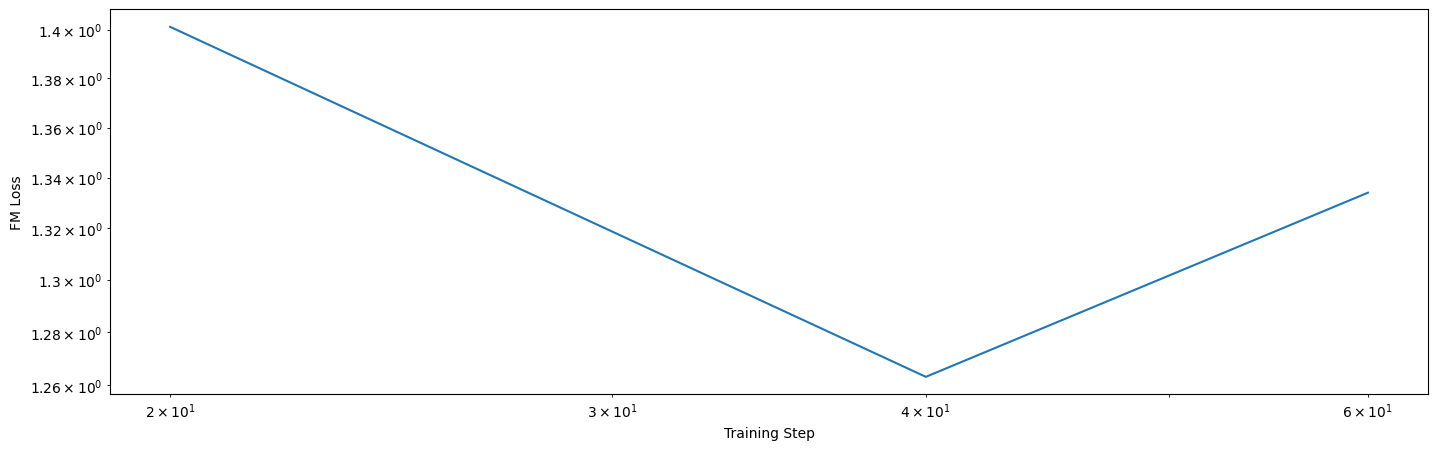

In [111]:
l_curve_fm = np.array(l_curve)
plt.loglog(l_curve_fm[1:,0],l_curve_fm[1:,1])
plt.xlabel('Training Step')
plt.ylabel('FM Loss')
plt.show()

In [112]:
xx0 = ising0.sample(1000).detach()
xx0 = xx0.detach().numpy()
t_range = np.linspace(0.1,0.249,32)
dt = t_range[1]-t_range[0]
for i in range(len(t_range)):
    dxx = model(torch.from_numpy(xx0).reshape(1000,6,6,1), torch.ones(1000)*0.1).detach().numpy()/safe_factor*dt
    xx1 = xx0.reshape(1000,6,6)+dxx.reshape(1000,6,6)

In [113]:
ising_control = Ising(6,2,0.25)
xx1_control = ising_control.sample(1000, initial=torch.from_numpy(xx0))
xx1_control = xx1_control.detach().numpy()
xx1_control = xx1_control.reshape(1000,36)


(array([  1.,   1.,   2.,   5.,   6.,   8.,   3.,   9.,  13.,  18.,  28.,
         28.,  37.,  47.,  62.,  67.,  91., 107., 145., 189., 185., 221.,
        216., 298., 336., 367., 410., 464., 480., 555., 575., 626., 644.,
        699., 704., 700., 743., 840., 735., 725., 780., 783., 744., 754.,
        728., 736., 721., 700., 777., 702., 740., 752., 721., 721., 769.,
        736., 735., 769., 778., 768., 743., 789., 751., 680., 704., 673.,
        574., 545., 500., 462., 448., 410., 350., 294., 278., 251., 213.,
        227., 153., 139., 106.,  85.,  81.,  53.,  32.,  40.,  35.,  21.,
         16.,  11.,   9.,   4.,   5.,   2.,   4.,   4.,   2.,   1.,   0.,
          1.]),
 array([-5.48083019, -5.36857319, -5.25631666, -5.14405966, -5.03180313,
        -4.91954613, -4.8072896 , -4.6950326 , -4.58277607, -4.47051907,
        -4.35826254, -4.24600554, -4.13374901, -4.021492  , -3.90923524,
        -3.79697847, -3.68472171, -3.57246494, -3.46020818, -3.34795141,
        -3.23569465, -3.12

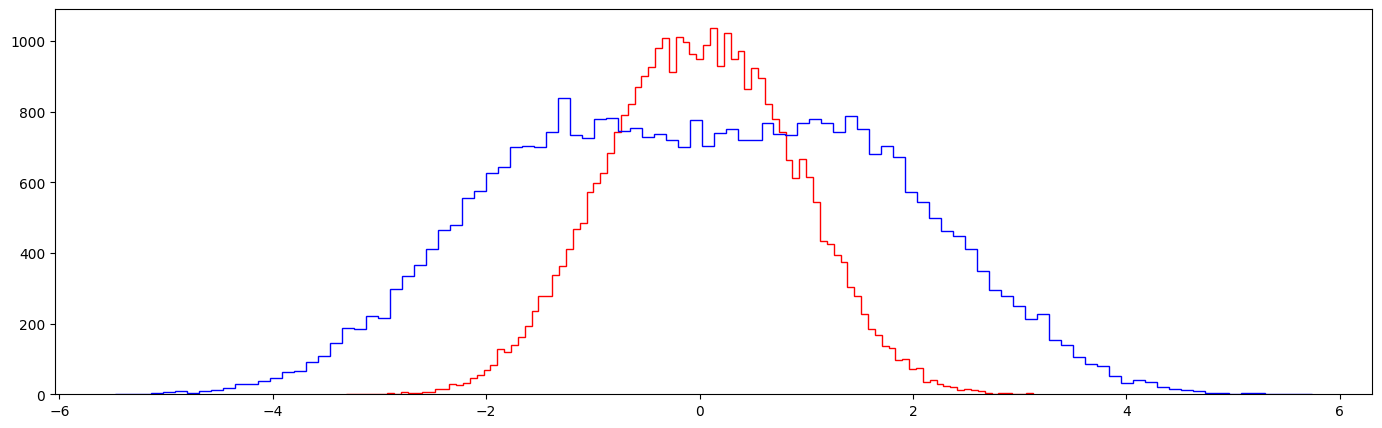

In [115]:

# plt.hist(xx0.reshape(-1), bins=100, edgecolor='black', histtype='step')
plt.hist(xx1.reshape(-1), bins=100, edgecolor='red', histtype='step')
plt.hist(xx1_control.reshape(-1), bins=100, edgecolor='blue', histtype='step')

(array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         1.,  2.,  6.,  6.,  4.,  3.,  8.,  3.,  5.,  4.,  3.,  5.,  6.,
         6.,  8., 11., 15.,  5., 10., 14., 16., 15., 15., 15., 29., 26.,
        18., 23., 26., 23., 30., 22., 21., 23., 27., 28., 33., 12., 28.,
        22., 26., 31., 28., 23., 27., 31., 19., 15., 18., 10., 20., 20.,
         9., 14., 11., 20., 12., 12., 12.,  4., 10.,  9.,  5.,  0.,  4.,
         1.,  5.,  0.,  4.,  3.,  4.,  2.,  1.,  1.,  4.,  1.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-70.07112885, -68.65292358, -67.23471069, -65.81650543,
        -64.39829254, -62.98008728, -61.5618782 , -60.14367294,
        -58.72546387, -57.30725479, -55.88904572, -54.47083664,
        -53.05263138, -51.6344223 , -50.21621323, -48.79800415,
        -47.37979889, -45.96158981, -44.54338074, -43.12517166,
        -41.70696259, -40.28875732, -38.87054825, -37.45233917,
        -36.0341301 , -34.61592102, -33.19771576, 

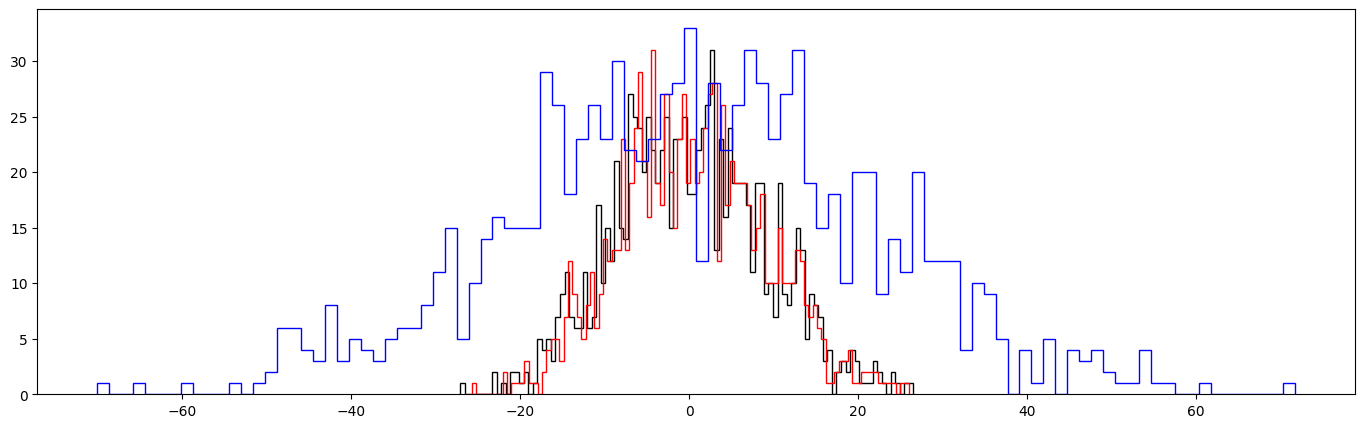

In [114]:
plt.hist(xx0.reshape(-1,36).sum(-1), bins=100, edgecolor='black', histtype='step')
plt.hist(xx1.reshape(-1,36).sum(-1), bins=100, edgecolor='red', histtype='step')
plt.hist(xx1_control.reshape(-1,36).sum(-1), bins=100, edgecolor='blue', histtype='step')

In [ ]:
l_curve = []
batch_size=250
ising0 = Ising(6,2,0.1)
ising1 = Ising(6,2,0.11)
ising2 = Ising(6,2,0.12)
ising3 = Ising(6,2,0.13)
# ising4 = Ising(6,2,0.14)
# ising5 = Ising(6,2,0.15)
# ising6 = Ising(6,2,0.16)
for t in range(20000):
    xx0 = ising0.sample(batch_size).detach()
    xx1 = ising1.sample(batch_size, initial=xx0).detach()
    xx2 = ising2.sample(batch_size, initial=xx1).detach()
    xx3 = ising3.sample(batch_size, initial=xx2).detach()
    xx0 = xx0.detach().numpy()
    xx1 = xx1.detach().numpy()
    xx2 = xx2.detach().numpy()
    xx3 = xx3.detach().numpy()
    dxx10 = (xx1-xx0).reshape(-1,6,6,1)
    t0 = torch.ones(batch_size)*0.1
    dxx21 = (xx2-xx1).reshape(-1,6,6,1)
    t1 = torch.ones(batch_size)*0.11
    dxx32 = (xx3-xx2).reshape(-1,6,6,1)
    t2 = torch.ones(batch_size)*0.12
    xx = np.concatenate([xx0,xx1,xx2], axis=0)
    dxx = np.concatenate([dxx10,dxx21,dxx32], axis=0)
    t = np.concatenate([t0,t1,t2], axis=0)
    loss = norm_loss(torch.from_numpy(xx), torch.from_numpy(dxx), torch.from_numpy(t))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if ((t % 20) == 0):
        l_curve.append([t,loss.item()])
    if ((t % 10) == 0):
        print([t,loss.item()])
    

In [ ]:
ising = Ising(6,2,0.25)
xx = ising.sample(1000, thermalSteps = 5000, interSteps=500, initial=xx)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx.reshape(-1,36)[:,0], xx.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx.reshape(-1,36).sum(-1), bins=100)

In [ ]:
ising = Ising(6,2,0.26)
xx = ising.sample(1000, initial=xx)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx.reshape(-1,36)[:,0], xx.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx.reshape(-1,36).sum(-1), bins=100)

In [ ]:
ising = Ising(6,2,0.28)
xx = ising.sample(1000, initial=xx)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx.reshape(-1,36)[:,0], xx.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx.reshape(-1,36).sum(-1), bins=100)

In [ ]:
ising = Ising(6,2,0.3)
xx = ising.sample(1000, initial=xx)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx.reshape(-1,36)[:,0], xx.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx.reshape(-1,36).sum(-1), bins=100)

In [ ]:
ising = Ising(6,2,0.4)
xx = ising.sample(1000, initial=xx)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx.reshape(-1,36)[:,0], xx.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx.reshape(-1,36).sum(-1), bins=100)